In [1]:
import datetime

import pandas as pd
import pandas_profiling as pdp
import numpy as np
from matplotlib import pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import lightgbm as lgb
import optuna.integration.lightgbm as lgb_opt

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

## データロード

In [2]:
# データロード
train_2018_df = pd.read_csv('../data/input/train_2018.csv')
train_2017_df = pd.read_csv('../data/input/train_2017.csv')
train_2016_df = pd.read_csv('../data/input/train_2016.csv')
train_2018_df['year'] = 2018
train_2017_df['year'] = 2017
train_2016_df['year'] = 2016

test_df = pd.read_csv('../data/input/test.csv')
test_df['year'] = 2019

In [3]:
# 教師データとテストデータのunion
all_df = pd.concat([train_2016_df, train_2017_df, train_2018_df, test_df], axis = 0).reset_index(drop=True)

In [4]:
# データ概要
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1902 entries, 0 to 1901
Data columns (total 37 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   1902 non-null   int64  
 1   team                 1902 non-null   object 
 2   No                   1902 non-null   float64
 3   name                 1902 non-null   object 
 4   time_played          1414 non-null   float64
 5   position             1902 non-null   object 
 6   birthdate            1902 non-null   object 
 7   height               1902 non-null   float64
 8   weight               1902 non-null   float64
 9   salary               1902 non-null   object 
 10  nth_year             1902 non-null   float64
 11  is_youth             341 non-null    float64
 12  nationality          276 non-null    object 
 13  j1_total_num_played  1640 non-null   float64
 14  j1_total_scores      1554 non-null   float64
 15  j2_total_num_played  1134 non-null   f

### 特徴量エンジニアリング

#### name

In [5]:
# nameのlabelencoding
le = LabelEncoder()
le = le.fit(all_df['name'])
all_df['name'] = le.transform(all_df['name'])

#### team

In [6]:
# teamはprevX_teamと同値のencodingを実施するため、辞書を作成
# 出現回数が1のものは同値でencodingを実施
# prevX_teamのencodingでも利用
team_dic = {}

tmp_dic = pd.concat([all_df['team'], all_df['prev3_team'], all_df['prev2_team'], all_df['prev1_team']]).value_counts().to_dict()
tmp_list = sorted(tmp_dic.items(), key = lambda x:x[1])

label = 0
for i, j in tmp_list:
    if j == 1:
        team_dic[i] = label
    else:
        team_dic[i] = label
        label += 1

# teamのlabelencoding
all_df['team'] = all_df['team'].map(team_dic)

#### potision

In [7]:
# potisionのlabelencoding
le = LabelEncoder()
le = le.fit(all_df['position'])
all_df['position'] = le.transform(all_df['position'])

#### birthdate

In [8]:
# 生年月日より生まれ年を抽出
all_df['birthdate'] = pd.to_datetime(all_df['birthdate'])
all_df['birthdate_year'] = all_df['birthdate'].dt.year

#### salary

In [9]:
# salaryのNaN→中央値補完
med_salary = all_df[all_df['salary'] != '-']['salary'].median()
all_df['salary'] = all_df['salary'].mask(all_df['salary'] == '-', med_salary)
all_df['salary'] = all_df['salary'].astype(float)

#### is_youth

In [10]:
# is_youthのboolean変換
all_df['is_youth'] = all_df['is_youth'].notnull()

#### nationality

In [11]:
# nationalityのNaN→Japan補完
all_df['nationality'] = all_df['nationality'].fillna('japan')

# nationalityのlabelencoding
le = LabelEncoder()
le = le.fit(all_df['nationality'])
all_df['nationality'] = le.transform(all_df['nationality'])

#### prevX_transferred

In [12]:
# prevX_teamに'・'が含まれているかで移籍有無を抽出
for col, new_col in {'prev3_team':'prev3_transferred', 'prev2_team':'prev2_transferred', 'prev1_team':'prev1_transferred',}.items():
    all_df[new_col] = all_df[col].str.contains('-')

#### prevX_team

In [13]:
# 作成した辞書を用いてprevX_teamのlabelencoding
for col in ['prev3_team', 'prev2_team', 'prev1_team']:
    all_df[col] = all_df[col].map(team_dic)

#### prevX_div

In [14]:
# prevX_divの'-'→0補完
for col in ['prev3_div', 'prev2_div', 'prev1_div']:
    all_df[col] = all_df[col].replace('-', 0).astype(int)

#### prevX_num_played

In [15]:
# prevX_num_playedの'-'→NaN補完
for col in ['prev3_num_played', 'prev2_num_played', 'prev1_num_played']:
    all_df[col] = all_df[col].replace('-', np.nan).astype(float)

#### prevX_scores

In [16]:
# prevX_scoresの'-'→NaN補完
for col in ['prev3_scores', 'prev2_scores', 'prev1_scores']:
    all_df[col] = all_df[col].replace('-', np.nan).astype(float)

#### prevX_time_played

In [17]:
# prevX_time_playedの'-'→NaN補完
for col in ['prev3_time_played', 'prev2_time_played', 'prev1_time_played']:
    all_df[col] = all_df[col].replace('-', np.nan).astype(float)

### 学習

In [18]:
# 前処理後データ概要
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1902 entries, 0 to 1901
Data columns (total 41 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id                   1902 non-null   int64         
 1   team                 1902 non-null   int64         
 2   No                   1902 non-null   float64       
 3   name                 1902 non-null   int32         
 4   time_played          1414 non-null   float64       
 5   position             1902 non-null   int32         
 6   birthdate            1902 non-null   datetime64[ns]
 7   height               1902 non-null   float64       
 8   weight               1902 non-null   float64       
 9   salary               1902 non-null   float64       
 10  nth_year             1902 non-null   float64       
 11  is_youth             1902 non-null   bool          
 12  nationality          1902 non-null   int32         
 13  j1_total_num_played  1640 non-nul

In [19]:
# 教師, 検証データ
x_train_valid_df = all_df[all_df['year'] < 2019]
y_train_valid_df = x_train_valid_df['time_played']

# バリデーション
# x_train, x_valid, y_train, y_valid = train_test_split(x_train_valid_df, y_train_valid_df, test_size=0.33, random_state=0, stratify = x_train_valid_df['year'])
x_train = x_train_valid_df[x_train_valid_df['year'] < 2018]
y_train = x_train['time_played']
x_valid = x_train_valid_df[x_train_valid_df['year'] == 2018]
y_valid = x_valid['time_played']

# テストデータ
test = all_df[all_df['year'] == 2019]

In [20]:
# 入力する特徴量
features = [
    'team',
    'position',
    'height',
    'weight',
    'salary',
    'nth_year',
    'is_youth',
    'nationality',
    'birthdate_year',
    'year',
    'j1_total_num_played',
    'j1_total_scores',
    'j2_total_num_played',
    'j2_total_scores',
    'j3_total_num_played',
    'j3_total_scores',
    'na_total_num_played',
    'na_total_scores',
    'prev3_transferred',
    'prev2_transferred',
    'prev1_transferred',
    'prev3_team',
    'prev2_team',
    'prev1_team',
    'prev3_div',
    'prev2_div',
    'prev1_div', 
    'prev3_num_played',
    'prev2_num_played',
    'prev1_num_played', 
    'prev3_scores',
    'prev2_scores',
    'prev1_scores', 
    'prev3_time_played',
    'prev2_time_played',
    'prev1_time_played'
]

In [21]:
# カテゴリ変数
categorical_features = ['team', 'position', 'nationality', 'prev3_team', 'prev2_team', 'prev1_team', 'prev3_div', 'prev2_div', 'prev1_div']

In [22]:
# lightgbmパラメータ
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'random_seed' : 0
}

In [23]:
# lightGBM用のデータセットを作成
lgb_train = lgb_opt.Dataset(x_train[features], y_train, categorical_feature = categorical_features, free_raw_data=False)
lgb_eval = lgb_opt.Dataset(x_valid[features], y_valid, categorical_feature = categorical_features, free_raw_data=False)

# モデルの作成
evals_result = {}
best_params = {}
model = lgb_opt.train(params = lgb_params,
                      train_set = lgb_train,
                      valid_sets = [lgb_train, lgb_eval],
                      categorical_feature = categorical_features,
                      verbose_eval = 10,
                      num_boost_round = 1000,
                      early_stopping_rounds = 20
)

# ベストパラメータの出力
best_params = model.params
print('=====Params======')
for key, value in best_params.items():
    print("  {}: {}".format(key, value))

# モデル精度の表示
valid_pred = model.predict(x_valid[features])
model_score = np.sqrt(metrics.mean_squared_error(valid_pred, y_valid))
print('=====Val score======')
print('  Val rmse score is {model_score}.'.format(model_score = model_score))

# テストデータの予測
y_pred = model.predict(test[features])

feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 743.566	valid_1's rmse: 883.48
[20]	training's rmse: 602.756	valid_1's rmse: 850.531
[30]	training's rmse: 519.04	valid_1's rmse: 853.669
[40]	training's rmse: 453.026	valid_1's rmse: 855.67
Early stopping, best iteration is:
[23]	training's rmse: 573.636	valid_1's rmse: 848.006


feature_fraction, val_score: 848.006061:  14%|######1                                    | 1/7 [00:00<00:00,  8.48it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 707.889	valid_1's rmse: 876.852
[20]	training's rmse: 569.898	valid_1's rmse: 860.067
[30]	training's rmse: 480.926	valid_1's rmse: 859.436
Early stopping, best iteration is:
[18]	training's rmse: 591.337	valid_1's rmse: 859.151


feature_fraction, val_score: 848.006061:  29%|############2                              | 2/7 [00:00<00:00,  8.48it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 694.9	valid_1's rmse: 873.98
[20]	training's rmse: 554.407	valid_1's rmse: 857.317
[30]	training's rmse: 461.1	valid_1's rmse: 857.279
[40]	training's rmse: 393.829	valid_1's rmse: 858.145
Early stopping, best iteration is:
[25]	training's rmse: 506.066	valid_1's rmse: 855.394


feature_fraction, val_score: 848.006061:  43%|##################4                        | 3/7 [00:00<00:00,  8.39it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 716.22	valid_1's rmse: 881.748
[20]	training's rmse: 571.221	valid_1's rmse: 862.858
[30]	training's rmse: 485.277	valid_1's rmse: 867.486
Early stopping, best iteration is:
[17]	training's rmse: 605.039	valid_1's rmse: 862.194


feature_fraction, val_score: 848.006061:  57%|########################5                  | 4/7 [00:00<00:00,  8.57it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 727.381	valid_1's rmse: 882.472
[20]	training's rmse: 583.554	valid_1's rmse: 858.859
[30]	training's rmse: 494.96	valid_1's rmse: 858.9
Early stopping, best iteration is:
[17]	training's rmse: 617.932	valid_1's rmse: 857.423


feature_fraction, val_score: 848.006061:  71%|##############################7            | 5/7 [00:00<00:00,  8.89it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 701.066	valid_1's rmse: 874.351
[20]	training's rmse: 558.024	valid_1's rmse: 859.481
[30]	training's rmse: 465.362	valid_1's rmse: 859.608
[40]	training's rmse: 395.625	valid_1's rmse: 865.903
Early stopping, best iteration is:
[25]	training's rmse: 507.007	valid_1's rmse: 858.52


feature_fraction, val_score: 848.006061:  86%|####################################8      | 6/7 [00:00<00:00,  8.08it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 703.669	valid_1's rmse: 875.669
[20]	training's rmse: 562.883	valid_1's rmse: 856.794
[30]	training's rmse: 474.699	valid_1's rmse: 857.468
[40]	training's rmse: 408.707	valid_1's rmse: 860.087
Early stopping, best iteration is:
[20]	training's rmse: 562.883	valid_1's rmse: 856.794


num_leaves, val_score: 848.006061:   0%|                                                        | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 738.575	valid_1's rmse: 885.718
[20]	training's rmse: 599.133	valid_1's rmse: 853.515
[30]	training's rmse: 511.225	valid_1's rmse: 852.893
[40]	training's rmse: 445.476	valid_1's rmse: 855.726
Early stopping, best iteration is:
[23]	training's rmse: 568.694	valid_1's rmse: 849.668


num_leaves, val_score: 848.006061:   5%|##4                                             | 1/20 [00:00<00:02,  8.70it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 740.146	valid_1's rmse: 882.912
[20]	training's rmse: 600.06	valid_1's rmse: 845.939
[30]	training's rmse: 509.281	valid_1's rmse: 847.193
[40]	training's rmse: 439.109	valid_1's rmse: 850.262
Early stopping, best iteration is:
[21]	training's rmse: 590.861	valid_1's rmse: 843.57


num_leaves, val_score: 843.569985:  10%|####8                                           | 2/20 [00:00<00:01,  9.01it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 738.575	valid_1's rmse: 885.718
[20]	training's rmse: 599.133	valid_1's rmse: 853.515
[30]	training's rmse: 511.225	valid_1's rmse: 852.893
[40]	training's rmse: 445.476	valid_1's rmse: 855.726
Early stopping, best iteration is:
[23]	training's rmse: 568.694	valid_1's rmse: 849.668


num_leaves, val_score: 843.569985:  15%|#######2                                        | 3/20 [00:00<00:01,  8.66it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 821.217	valid_1's rmse: 900.158
[20]	training's rmse: 729.771	valid_1's rmse: 860.087
[30]	training's rmse: 681.496	valid_1's rmse: 850.03
[40]	training's rmse: 647.07	valid_1's rmse: 849.063
[50]	training's rmse: 618.743	valid_1's rmse: 848.664
Early stopping, best iteration is:
[39]	training's rmse: 650.651	valid_1's rmse: 848.065


num_leaves, val_score: 843.569985:  20%|#########6                                      | 4/20 [00:00<00:01,  8.66it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 738.575	valid_1's rmse: 885.718
[20]	training's rmse: 599.133	valid_1's rmse: 853.515
[30]	training's rmse: 511.225	valid_1's rmse: 852.893
[40]	training's rmse: 445.476	valid_1's rmse: 855.726
Early stopping, best iteration is:
[23]	training's rmse: 568.694	valid_1's rmse: 849.668


num_leaves, val_score: 843.569985:  25%|############                                    | 5/20 [00:00<00:01,  9.02it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 738.575	valid_1's rmse: 885.718
[20]	training's rmse: 599.133	valid_1's rmse: 853.515
[30]	training's rmse: 511.225	valid_1's rmse: 852.893
[40]	training's rmse: 445.476	valid_1's rmse: 855.726
Early stopping, best iteration is:
[23]	training's rmse: 568.694	valid_1's rmse: 849.668


num_leaves, val_score: 843.569985:  30%|##############4                                 | 6/20 [00:00<00:01,  8.43it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 738.575	valid_1's rmse: 885.718
[20]	training's rmse: 599.133	valid_1's rmse: 853.515
[30]	training's rmse: 511.225	valid_1's rmse: 852.893
[40]	training's rmse: 445.476	valid_1's rmse: 855.726
Early stopping, best iteration is:
[23]	training's rmse: 568.694	valid_1's rmse: 849.668


num_leaves, val_score: 843.569985:  35%|################7                               | 7/20 [00:00<00:01,  8.34it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 836.84	valid_1's rmse: 903.637
[20]	training's rmse: 751.403	valid_1's rmse: 861.643
[30]	training's rmse: 709.483	valid_1's rmse: 853.699
[40]	training's rmse: 680.403	valid_1's rmse: 849.59
[50]	training's rmse: 656.397	valid_1's rmse: 846.032
[60]	training's rmse: 635.547	valid_1's rmse: 846.703
[70]	training's rmse: 618.952	valid_1's rmse: 846.123
[80]	training's rmse: 601.784	valid_1's rmse: 849.491
Early stopping, best iteration is:
[69]	training's rmse: 620.505	valid_1's rmse: 845.638


num_leaves, val_score: 843.569985:  40%|###################2                            | 8/20 [00:01<00:01,  6.92it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 803.891	valid_1's rmse: 895.373
[20]	training's rmse: 697.587	valid_1's rmse: 858.689
[30]	training's rmse: 642.55	valid_1's rmse: 856.696
[40]	training's rmse: 602.918	valid_1's rmse: 858.551
Early stopping, best iteration is:
[23]	training's rmse: 677.697	valid_1's rmse: 855.419


num_leaves, val_score: 843.569985:  45%|#####################6                          | 9/20 [00:01<00:01,  6.92it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 738.575	valid_1's rmse: 885.718
[20]	training's rmse: 599.133	valid_1's rmse: 853.515
[30]	training's rmse: 511.225	valid_1's rmse: 852.893
[40]	training's rmse: 445.476	valid_1's rmse: 855.726
Early stopping, best iteration is:
[23]	training's rmse: 568.694	valid_1's rmse: 849.668


num_leaves, val_score: 843.569985:  50%|#######################5                       | 10/20 [00:01<00:01,  7.75it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 780.291	valid_1's rmse: 894.1
[20]	training's rmse: 660.558	valid_1's rmse: 857.441
[30]	training's rmse: 593.64	valid_1's rmse: 850.534
[40]	training's rmse: 545.411	valid_1's rmse: 853.401
Early stopping, best iteration is:
[26]	training's rmse: 617.051	valid_1's rmse: 850.417


num_leaves, val_score: 843.569985:  55%|#########################8                     | 11/20 [00:01<00:01,  7.75it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 738.575	valid_1's rmse: 885.718
[20]	training's rmse: 599.133	valid_1's rmse: 853.515
[30]	training's rmse: 511.225	valid_1's rmse: 852.893
[40]	training's rmse: 445.476	valid_1's rmse: 855.726
Early stopping, best iteration is:
[23]	training's rmse: 568.694	valid_1's rmse: 849.668


num_leaves, val_score: 843.569985:  60%|############################2                  | 12/20 [00:01<00:01,  7.77it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 738.575	valid_1's rmse: 885.718
[20]	training's rmse: 599.133	valid_1's rmse: 853.515
[30]	training's rmse: 511.225	valid_1's rmse: 852.893
[40]	training's rmse: 445.476	valid_1's rmse: 855.726
Early stopping, best iteration is:
[23]	training's rmse: 568.694	valid_1's rmse: 849.668


num_leaves, val_score: 843.569985:  65%|##############################5                | 13/20 [00:01<00:00,  7.91it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 836.84	valid_1's rmse: 903.637
[20]	training's rmse: 751.403	valid_1's rmse: 861.643
[30]	training's rmse: 709.483	valid_1's rmse: 853.699
[40]	training's rmse: 680.403	valid_1's rmse: 849.59
[50]	training's rmse: 656.397	valid_1's rmse: 846.032
[60]	training's rmse: 635.547	valid_1's rmse: 846.703
[70]	training's rmse: 618.952	valid_1's rmse: 846.123
[80]	training's rmse: 601.784	valid_1's rmse: 849.491
Early stopping, best iteration is:
[69]	training's rmse: 620.505	valid_1's rmse: 845.638


num_leaves, val_score: 843.569985:  70%|################################9              | 14/20 [00:01<00:00,  7.91it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 855.998	valid_1's rmse: 913.643
[20]	training's rmse: 783.979	valid_1's rmse: 871.555
[30]	training's rmse: 749.461	valid_1's rmse: 856.911
[40]	training's rmse: 727.068	valid_1's rmse: 855.844
[50]	training's rmse: 709.111	valid_1's rmse: 853.113
[60]	training's rmse: 692.89	valid_1's rmse: 852.911
[70]	training's rmse: 679.715	valid_1's rmse: 854.268
[80]	training's rmse: 665.858	valid_1's rmse: 852.039
[90]	training's rmse: 655.726	valid_1's rmse: 851.639
[100]	training's rmse: 645.365	valid_1's rmse: 852.47
Early stopping, best iteration is:
[85]	training's rmse: 660.658	valid_1's rmse: 850.979


num_leaves, val_score: 843.569985:  75%|###################################2           | 15/20 [00:01<00:00,  8.40it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 892.775	valid_1's rmse: 940.241
[20]	training's rmse: 837.506	valid_1's rmse: 894.786
[30]	training's rmse: 813.324	valid_1's rmse: 877.631
[40]	training's rmse: 798.199	valid_1's rmse: 872.591
[50]	training's rmse: 787.103	valid_1's rmse: 868.385
[60]	training's rmse: 778.63	valid_1's rmse: 866.03
[70]	training's rmse: 771.841	valid_1's rmse: 863.209
[80]	training's rmse: 765.927	valid_1's rmse: 862.991
[90]	training's rmse: 760.592	valid_1's rmse: 860.807
[100]	training's rmse: 755.684	valid_1's rmse: 858.404
[110]	training's rmse: 751.222	valid_1's rmse: 857.102
[120]	training's rmse: 747.192	valid_1's rmse: 856.943
[130]	training's rmse: 743.447	valid_1's rmse: 854.894
[140]	training's rmse: 739.907	valid_1's rmse: 853.202
[150]	training's rmse: 736.612	valid_1's rmse: 853.076
[160]	training's rmse: 733.641	valid_1's rmse: 852.951
[170]	training's rmse: 730.643	valid_1's rmse: 851.777
[180]	training'

num_leaves, val_score: 843.569985:  80%|#####################################6         | 16/20 [00:01<00:00,  7.76it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 738.575	valid_1's rmse: 885.718
[20]	training's rmse: 599.133	valid_1's rmse: 853.515
[30]	training's rmse: 511.225	valid_1's rmse: 852.893
[40]	training's rmse: 445.476	valid_1's rmse: 855.726
Early stopping, best iteration is:
[23]	training's rmse: 568.694	valid_1's rmse: 849.668


num_leaves, val_score: 843.569985:  85%|#######################################9       | 17/20 [00:02<00:00,  7.92it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 738.575	valid_1's rmse: 885.718
[20]	training's rmse: 599.133	valid_1's rmse: 853.515
[30]	training's rmse: 511.225	valid_1's rmse: 852.893
[40]	training's rmse: 445.476	valid_1's rmse: 855.726
Early stopping, best iteration is:
[23]	training's rmse: 568.694	valid_1's rmse: 849.668


num_leaves, val_score: 843.569985:  90%|##########################################3    | 18/20 [00:02<00:00,  8.12it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 742.013	valid_1's rmse: 882.943
[20]	training's rmse: 601.471	valid_1's rmse: 848.23
[30]	training's rmse: 516.77	valid_1's rmse: 851.4
[40]	training's rmse: 452.784	valid_1's rmse: 852.335
Early stopping, best iteration is:
[21]	training's rmse: 591.695	valid_1's rmse: 847.37


num_leaves, val_score: 843.569985:  95%|############################################6  | 19/20 [00:02<00:00,  8.12it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 738.575	valid_1's rmse: 885.718
[20]	training's rmse: 599.133	valid_1's rmse: 853.515
[30]	training's rmse: 511.225	valid_1's rmse: 852.893
[40]	training's rmse: 445.476	valid_1's rmse: 855.726
Early stopping, best iteration is:
[23]	training's rmse: 568.694	valid_1's rmse: 849.668


bagging, val_score: 843.569985:   0%|                                                           | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 752.229	valid_1's rmse: 888.952
[20]	training's rmse: 620.403	valid_1's rmse: 862.494
[30]	training's rmse: 541.274	valid_1's rmse: 856.221
[40]	training's rmse: 479.815	valid_1's rmse: 859.957
[50]	training's rmse: 425.765	valid_1's rmse: 860.821
Early stopping, best iteration is:
[32]	training's rmse: 527.635	valid_1's rmse: 854.512


bagging, val_score: 843.569985:  10%|#####1                                             | 1/10 [00:00<00:01,  7.58it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 812.777	valid_1's rmse: 907.336
[20]	training's rmse: 730.824	valid_1's rmse: 863.875
[30]	training's rmse: 677.949	valid_1's rmse: 865.056
[40]	training's rmse: 645.283	valid_1's rmse: 863.448
Early stopping, best iteration is:
[24]	training's rmse: 706.74	valid_1's rmse: 860.609


bagging, val_score: 843.569985:  20%|##########2                                        | 2/10 [00:00<00:01,  7.58it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 804.848	valid_1's rmse: 900.107
[20]	training's rmse: 721.42	valid_1's rmse: 866.56
[30]	training's rmse: 667.721	valid_1's rmse: 868.267
[40]	training's rmse: 630.308	valid_1's rmse: 872.565
Early stopping, best iteration is:
[24]	training's rmse: 696.002	valid_1's rmse: 864.257


bagging, val_score: 843.569985:  30%|###############3                                   | 3/10 [00:00<00:00,  8.44it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 745.601	valid_1's rmse: 889.25
[20]	training's rmse: 604.772	valid_1's rmse: 860.354
[30]	training's rmse: 519.814	valid_1's rmse: 856.101
[40]	training's rmse: 452.238	valid_1's rmse: 860.251
Early stopping, best iteration is:
[27]	training's rmse: 542.729	valid_1's rmse: 854.595


bagging, val_score: 843.569985:  40%|####################4                              | 4/10 [00:00<00:00,  8.23it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 782.226	valid_1's rmse: 896.419
[20]	training's rmse: 666.803	valid_1's rmse: 859.69
[30]	training's rmse: 599.108	valid_1's rmse: 851.09
[40]	training's rmse: 546.927	valid_1's rmse: 851.414
[50]	training's rmse: 501.53	valid_1's rmse: 858.281
Early stopping, best iteration is:
[35]	training's rmse: 571.912	valid_1's rmse: 845.809


bagging, val_score: 843.569985:  50%|#########################5                         | 5/10 [00:00<00:00,  8.16it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 781.28	valid_1's rmse: 895.193
[20]	training's rmse: 668.205	valid_1's rmse: 858.813
[30]	training's rmse: 600.507	valid_1's rmse: 853.487
[40]	training's rmse: 546.838	valid_1's rmse: 855.181
Early stopping, best iteration is:
[29]	training's rmse: 605.658	valid_1's rmse: 852.58


bagging, val_score: 843.569985:  60%|##############################6                    | 6/10 [00:00<00:00,  8.38it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 774.13	valid_1's rmse: 889.887
[20]	training's rmse: 657.779	valid_1's rmse: 853.239
[30]	training's rmse: 591.261	valid_1's rmse: 848.522
[40]	training's rmse: 538.651	valid_1's rmse: 852.636
[50]	training's rmse: 493.013	valid_1's rmse: 856.57
Early stopping, best iteration is:
[31]	training's rmse: 584.835	valid_1's rmse: 848.221


bagging, val_score: 843.569985:  70%|###################################6               | 7/10 [00:00<00:00,  8.49it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 793.221	valid_1's rmse: 893.967
[20]	training's rmse: 690.195	valid_1's rmse: 858.935
[30]	training's rmse: 628.861	valid_1's rmse: 854.092
[40]	training's rmse: 585.538	valid_1's rmse: 857.28
[50]	training's rmse: 550.901	valid_1's rmse: 870.109
Early stopping, best iteration is:
[37]	training's rmse: 598.37	valid_1's rmse: 853.358


bagging, val_score: 843.569985:  80%|########################################8          | 8/10 [00:00<00:00,  8.51it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 761.128	valid_1's rmse: 875.975
[20]	training's rmse: 635.383	valid_1's rmse: 845.959
[30]	training's rmse: 558.97	valid_1's rmse: 846.652
[40]	training's rmse: 500.967	valid_1's rmse: 848.455
Early stopping, best iteration is:
[23]	training's rmse: 610.149	valid_1's rmse: 843.513


bagging, val_score: 843.513351:  90%|#############################################9     | 9/10 [00:01<00:00,  8.72it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 760.676	valid_1's rmse: 876.085
[20]	training's rmse: 636.38	valid_1's rmse: 844.876
[30]	training's rmse: 563.213	valid_1's rmse: 842.805
[40]	training's rmse: 504.92	valid_1's rmse: 847.337
[50]	training's rmse: 453.68	valid_1's rmse: 854.256
Early stopping, best iteration is:
[32]	training's rmse: 550.127	valid_1's rmse: 841.063


feature_fraction_stage2, val_score: 841.062782:   0%|                                            | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 752.858	valid_1's rmse: 880.787
[20]	training's rmse: 629.362	valid_1's rmse: 851.423
[30]	training's rmse: 547.827	valid_1's rmse: 855.298
[40]	training's rmse: 491.576	valid_1's rmse: 857.901
Early stopping, best iteration is:
[21]	training's rmse: 619.017	valid_1's rmse: 850.3


feature_fraction_stage2, val_score: 841.062782:  33%|############                        | 1/3 [00:00<00:00,  9.53it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 753.458	valid_1's rmse: 880.509
[20]	training's rmse: 632.027	valid_1's rmse: 857.752
[30]	training's rmse: 550.817	valid_1's rmse: 857.37
Early stopping, best iteration is:
[17]	training's rmse: 658.564	valid_1's rmse: 855.602


feature_fraction_stage2, val_score: 841.062782:  67%|########################            | 2/3 [00:00<00:00, 10.64it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 752.897	valid_1's rmse: 882.202
[20]	training's rmse: 625.568	valid_1's rmse: 852.603
[30]	training's rmse: 547.168	valid_1's rmse: 853.861
[40]	training's rmse: 486.406	valid_1's rmse: 855.612
Early stopping, best iteration is:
[21]	training's rmse: 616.59	valid_1's rmse: 851.988


regularization_factors, val_score: 841.062782:   0%|                                            | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 760.677	valid_1's rmse: 876.086
[20]	training's rmse: 636.381	valid_1's rmse: 844.877
[30]	training's rmse: 563.215	valid_1's rmse: 842.805
[40]	training's rmse: 504.922	valid_1's rmse: 847.337
[50]	training's rmse: 453.682	valid_1's rmse: 854.256
Early stopping, best iteration is:
[32]	training's rmse: 550.128	valid_1's rmse: 841.063


regularization_factors, val_score: 841.062709:   5%|#8                                  | 1/20 [00:00<00:02,  6.95it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 760.683	valid_1's rmse: 876.073
[20]	training's rmse: 636.392	valid_1's rmse: 844.886
[30]	training's rmse: 562.199	valid_1's rmse: 843.207
[40]	training's rmse: 503.237	valid_1's rmse: 850.359
Early stopping, best iteration is:
[27]	training's rmse: 580.288	valid_1's rmse: 842.477


regularization_factors, val_score: 841.062709:  10%|###6                                | 2/20 [00:00<00:02,  7.30it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 760.682	valid_1's rmse: 876.072
[20]	training's rmse: 636.392	valid_1's rmse: 844.886
[30]	training's rmse: 562.198	valid_1's rmse: 843.207
[40]	training's rmse: 503.236	valid_1's rmse: 850.359
Early stopping, best iteration is:
[27]	training's rmse: 580.287	valid_1's rmse: 842.477


regularization_factors, val_score: 841.062709:  15%|#####3                              | 3/20 [00:00<00:02,  7.53it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 760.683	valid_1's rmse: 876.072
[20]	training's rmse: 636.392	valid_1's rmse: 844.886
[30]	training's rmse: 562.198	valid_1's rmse: 843.207
[40]	training's rmse: 503.236	valid_1's rmse: 850.359
Early stopping, best iteration is:
[27]	training's rmse: 580.288	valid_1's rmse: 842.477


regularization_factors, val_score: 841.062709:  20%|#######2                            | 4/20 [00:00<00:02,  7.83it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 760.684	valid_1's rmse: 876.073
[20]	training's rmse: 636.394	valid_1's rmse: 844.886
[30]	training's rmse: 562.2	valid_1's rmse: 843.207
[40]	training's rmse: 503.239	valid_1's rmse: 850.358
Early stopping, best iteration is:
[27]	training's rmse: 580.29	valid_1's rmse: 842.477


regularization_factors, val_score: 841.062709:  25%|#########                           | 5/20 [00:00<00:01,  8.03it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 760.683	valid_1's rmse: 876.073
[20]	training's rmse: 636.393	valid_1's rmse: 844.886
[30]	training's rmse: 562.199	valid_1's rmse: 843.207
[40]	training's rmse: 503.238	valid_1's rmse: 850.359
Early stopping, best iteration is:
[27]	training's rmse: 580.288	valid_1's rmse: 842.477


regularization_factors, val_score: 841.062709:  30%|##########7                         | 6/20 [00:00<00:01,  8.16it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 760.682	valid_1's rmse: 876.072
[20]	training's rmse: 636.392	valid_1's rmse: 844.886
[30]	training's rmse: 562.197	valid_1's rmse: 843.207
[40]	training's rmse: 503.236	valid_1's rmse: 850.359
Early stopping, best iteration is:
[27]	training's rmse: 580.287	valid_1's rmse: 842.477


regularization_factors, val_score: 841.062709:  35%|############6                       | 7/20 [00:00<00:01,  8.28it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 760.677	valid_1's rmse: 876.086
[20]	training's rmse: 636.381	valid_1's rmse: 844.877
[30]	training's rmse: 563.215	valid_1's rmse: 842.805
[40]	training's rmse: 504.922	valid_1's rmse: 847.337
[50]	training's rmse: 453.683	valid_1's rmse: 854.256
Early stopping, best iteration is:
[32]	training's rmse: 550.128	valid_1's rmse: 841.063


regularization_factors, val_score: 841.062700:  40%|##############4                     | 8/20 [00:00<00:01,  8.17it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 792.531	valid_1's rmse: 896.679
[20]	training's rmse: 678.531	valid_1's rmse: 856.081
[30]	training's rmse: 609.801	valid_1's rmse: 849.158
[40]	training's rmse: 555.638	valid_1's rmse: 853.153
[50]	training's rmse: 506.594	valid_1's rmse: 855.194
Early stopping, best iteration is:
[32]	training's rmse: 597.369	valid_1's rmse: 847.884


regularization_factors, val_score: 841.062700:  45%|################2                   | 9/20 [00:01<00:01,  8.00it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 760.677	valid_1's rmse: 876.085
[20]	training's rmse: 636.38	valid_1's rmse: 844.876
[30]	training's rmse: 563.213	valid_1's rmse: 842.805
[40]	training's rmse: 504.92	valid_1's rmse: 847.337
[50]	training's rmse: 453.68	valid_1's rmse: 854.256
Early stopping, best iteration is:
[32]	training's rmse: 550.127	valid_1's rmse: 841.063


regularization_factors, val_score: 841.062700:  50%|#################5                 | 10/20 [00:01<00:01,  7.89it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 760.677	valid_1's rmse: 876.085
[20]	training's rmse: 636.38	valid_1's rmse: 844.876
[30]	training's rmse: 563.213	valid_1's rmse: 842.805
[40]	training's rmse: 504.92	valid_1's rmse: 847.337
[50]	training's rmse: 453.68	valid_1's rmse: 854.256
Early stopping, best iteration is:
[32]	training's rmse: 550.127	valid_1's rmse: 841.063


regularization_factors, val_score: 841.062700:  55%|###################2               | 11/20 [00:01<00:01,  7.83it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 760.677	valid_1's rmse: 876.085
[20]	training's rmse: 636.38	valid_1's rmse: 844.876
[30]	training's rmse: 563.213	valid_1's rmse: 842.805
[40]	training's rmse: 504.921	valid_1's rmse: 847.337
[50]	training's rmse: 453.681	valid_1's rmse: 854.256
Early stopping, best iteration is:
[32]	training's rmse: 550.127	valid_1's rmse: 841.063


regularization_factors, val_score: 841.062700:  60%|#####################              | 12/20 [00:01<00:01,  7.74it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 760.677	valid_1's rmse: 876.085
[20]	training's rmse: 636.38	valid_1's rmse: 844.876
[30]	training's rmse: 563.213	valid_1's rmse: 842.805
[40]	training's rmse: 504.92	valid_1's rmse: 847.337
[50]	training's rmse: 453.68	valid_1's rmse: 854.256
Early stopping, best iteration is:
[32]	training's rmse: 550.127	valid_1's rmse: 841.063


regularization_factors, val_score: 841.062700:  65%|######################7            | 13/20 [00:01<00:00,  7.78it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 760.677	valid_1's rmse: 876.085
[20]	training's rmse: 636.38	valid_1's rmse: 844.876
[30]	training's rmse: 563.213	valid_1's rmse: 842.805
[40]	training's rmse: 504.92	valid_1's rmse: 847.337
[50]	training's rmse: 453.68	valid_1's rmse: 854.256
Early stopping, best iteration is:
[32]	training's rmse: 550.127	valid_1's rmse: 841.063


regularization_factors, val_score: 841.062700:  70%|########################5          | 14/20 [00:01<00:00,  7.44it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 760.677	valid_1's rmse: 876.085
[20]	training's rmse: 636.38	valid_1's rmse: 844.876
[30]	training's rmse: 563.213	valid_1's rmse: 842.805
[40]	training's rmse: 504.921	valid_1's rmse: 847.337
[50]	training's rmse: 453.68	valid_1's rmse: 854.256
Early stopping, best iteration is:
[32]	training's rmse: 550.127	valid_1's rmse: 841.063


regularization_factors, val_score: 841.062700:  75%|##########################2        | 15/20 [00:01<00:00,  7.29it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 760.677	valid_1's rmse: 876.086
[20]	training's rmse: 636.38	valid_1's rmse: 844.877
[30]	training's rmse: 563.214	valid_1's rmse: 842.805
[40]	training's rmse: 504.921	valid_1's rmse: 847.337
[50]	training's rmse: 453.681	valid_1's rmse: 854.256
Early stopping, best iteration is:
[32]	training's rmse: 550.127	valid_1's rmse: 841.063


regularization_factors, val_score: 841.062700:  80%|############################       | 16/20 [00:02<00:00,  7.41it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 760.687	valid_1's rmse: 876.075
[20]	training's rmse: 636.396	valid_1's rmse: 844.886
[30]	training's rmse: 562.202	valid_1's rmse: 843.207
[40]	training's rmse: 503.24	valid_1's rmse: 850.359
Early stopping, best iteration is:
[27]	training's rmse: 580.291	valid_1's rmse: 842.477


regularization_factors, val_score: 841.062700:  85%|#############################7     | 17/20 [00:02<00:00,  7.61it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 760.683	valid_1's rmse: 876.073
[20]	training's rmse: 636.392	valid_1's rmse: 844.886
[30]	training's rmse: 562.198	valid_1's rmse: 843.207
[40]	training's rmse: 503.235	valid_1's rmse: 850.359
Early stopping, best iteration is:
[27]	training's rmse: 580.287	valid_1's rmse: 842.477


regularization_factors, val_score: 841.062700:  90%|###############################5   | 18/20 [00:02<00:00,  7.76it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 760.677	valid_1's rmse: 876.086
[20]	training's rmse: 636.38	valid_1's rmse: 844.877
[30]	training's rmse: 563.214	valid_1's rmse: 842.805
[40]	training's rmse: 504.921	valid_1's rmse: 847.337
[50]	training's rmse: 453.681	valid_1's rmse: 854.256
Early stopping, best iteration is:
[32]	training's rmse: 550.127	valid_1's rmse: 841.063


regularization_factors, val_score: 841.062700:  95%|#################################2 | 19/20 [00:02<00:00,  7.78it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 760.676	valid_1's rmse: 876.085
[20]	training's rmse: 636.38	valid_1's rmse: 844.876
[30]	training's rmse: 563.213	valid_1's rmse: 842.805
[40]	training's rmse: 504.92	valid_1's rmse: 847.337
[50]	training's rmse: 453.68	valid_1's rmse: 854.256
Early stopping, best iteration is:
[32]	training's rmse: 550.127	valid_1's rmse: 841.063


min_data_in_leaf, val_score: 841.062700:   0%|                                                   | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 851.886	valid_1's rmse: 907.629
[20]	training's rmse: 782.487	valid_1's rmse: 869.387
[30]	training's rmse: 744.848	valid_1's rmse: 856.974
[40]	training's rmse: 719.189	valid_1's rmse: 854.142
[50]	training's rmse: 698.264	valid_1's rmse: 848.295
[60]	training's rmse: 682.072	valid_1's rmse: 851.077
[70]	training's rmse: 668.344	valid_1's rmse: 850.109
Early stopping, best iteration is:
[51]	training's rmse: 696.788	valid_1's rmse: 847.973


min_data_in_leaf, val_score: 841.062700:  20%|########6                                  | 1/5 [00:00<00:00,  9.10it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 774.852	valid_1's rmse: 885.346
[20]	training's rmse: 660.295	valid_1's rmse: 853.957
[30]	training's rmse: 593.294	valid_1's rmse: 854.679
[40]	training's rmse: 541.247	valid_1's rmse: 851.979
[50]	training's rmse: 495.663	valid_1's rmse: 854.115
Early stopping, best iteration is:
[38]	training's rmse: 552.273	valid_1's rmse: 850.503


min_data_in_leaf, val_score: 841.062700:  40%|#################2                         | 2/5 [00:00<00:00,  9.35it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 712.022	valid_1's rmse: 883.301
[20]	training's rmse: 564.887	valid_1's rmse: 862.665
[30]	training's rmse: 471.228	valid_1's rmse: 864.23
[40]	training's rmse: 401.679	valid_1's rmse: 871.761
Early stopping, best iteration is:
[21]	training's rmse: 552.792	valid_1's rmse: 859.968


min_data_in_leaf, val_score: 841.062700:  60%|#########################8                 | 3/5 [00:00<00:00,  9.17it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 698.702	valid_1's rmse: 887.635
[20]	training's rmse: 542.478	valid_1's rmse: 857.847
[30]	training's rmse: 443.592	valid_1's rmse: 862.167
[40]	training's rmse: 371.09	valid_1's rmse: 870.758
Early stopping, best iteration is:
[21]	training's rmse: 530.563	valid_1's rmse: 856.167


min_data_in_leaf, val_score: 841.062700:  80%|##################################4        | 4/5 [00:00<00:00,  8.70it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 820.72	valid_1's rmse: 900.993
[20]	training's rmse: 728.543	valid_1's rmse: 863.543
[30]	training's rmse: 679.279	valid_1's rmse: 858.741
[40]	training's rmse: 642.708	valid_1's rmse: 860.036
[50]	training's rmse: 612.172	valid_1's rmse: 863.063
Early stopping, best iteration is:
[34]	training's rmse: 664.356	valid_1's rmse: 856.283


min_data_in_leaf, val_score: 841.062700: 100%|###########################################| 5/5 [00:00<00:00,  9.20it/s]


=====Params======
  objective: regression
  metric: rmse
  random_seed: 0
  lambda_l1: 0.10651626088831287
  lambda_l2: 1.0053259642257164e-08
  num_leaves: 37
  feature_fraction: 0.4
  bagging_fraction: 0.8094923473369776
  bagging_freq: 5
  min_child_samples: 20
=====Val score======
  Val rmse score is 841.0627001335343.


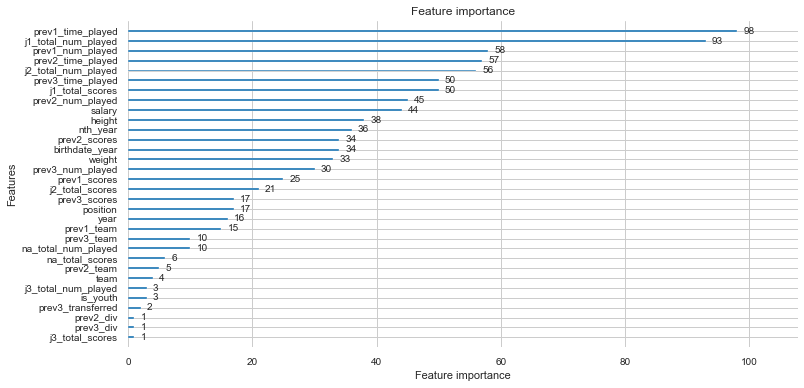

In [24]:
lgb.plot_importance(model, figsize=(12, 6))
plt.show()

### 出力

In [25]:
# 提出用データの作成
sub = test[['id', 'time_played']].copy()
sub['time_played'] = y_pred

# csvの出力
now = datetime.datetime.now()
sub_name = '特徴量追加(prevX_transferred,prevX_team,prevX_div,prevX_num_played,prevX_scores,prevX_time_played)'
file_name = '../data/output/sub_' + sub_name + '_' + now.strftime('%Y%m%d_%H%M%S') + '.csv'
sub.to_csv(file_name, index=False)